In [1]:
import os
import sys
import time
from pathlib import Path

import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from PIL import Image

from col_dtypes import ColDataTypes

In [2]:
data_folder = "../../data/" # root data folder
dpi = 50 # spectrogram image resolution

chunk_id = 2 # chunk 1 is noise, chunks 2-6 are earthquake signals
assert chunk_id > 0 and chunk_id <= 6

print(f'Analysing chunk {chunk_id}')

Analysing chunk 2


In [3]:
col_dtypes = ColDataTypes()
dtypes = col_dtypes.get_initial_dtype_dict()
date_cols = col_dtypes.get_date_cols()

csv_pth = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}.csv') # chunk metadata

chunk = pd.read_csv(csv_pth, dtype=dtypes, parse_dates=date_cols, encoding='utf-8')

processed_csv_save_pth = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}_processed.csv') # processed metadata save pth
processedChunk = pd.read_csv(processed_csv_save_pth, dtype=dtypes, parse_dates=date_cols, encoding='utf-8')

print(chunk.columns)
print(chunk.shape)
chunk.head()

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')
(200000, 35)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,17.080000,...,None,None,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],[[2896.]],59:01.0,earthquake_local,109C.TA_20060723155859_EV
1,TA,109C,BH,32.8889,-117.1051,150.0,600.0,manual,0.5,16.879999,...,None,None,0.91,101.34,281.7,[65. 65.5 61.40000153],[[5508.]],56:53.6,earthquake_local,109C.TA_20061103155652_EV
2,TA,109C,BH,32.8889,-117.1051,150.0,500.0,manual,0.5,17.260000,...,None,None,0.92,101.87,280.5,[37.20000076 42. 38.59999847],[[3114.]],12:24.7,earthquake_local,109C.TA_20061103161223_EV
3,TA,109C,BH,32.8889,-117.1051,150.0,900.0,manual,0.5,17.280001,...,None,None,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],[[3152.]],32:22.5,earthquake_local,109C.TA_20061114133221_EV
4,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,18.139999,...,None,None,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],[[3134.]],46:41.1,earthquake_local,109C.TA_20061127104640_EV


# Understanding the Processed Data
Processed Data has been filtered to obtain the P and S-waves

In [4]:
print(processedChunk.columns)
print(processedChunk.shape)
processedChunk.head()

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name', 'same_status?',
       'p_duration', 's_duration'],
      dtype='object')
(81750, 38)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name,same_status?,p_duration,s_duration
0,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,17.080000,...,102.09,159.3,[56.79999924 55.40000153 47.40000153],2896,59:01.0,earthquake_local,109C.TA_20060723155859_EV,True,1194.0,1002.0
1,TA,109C,BH,32.8889,-117.1051,150.0,600.0,manual,0.5,16.879999,...,101.34,281.7,[65. 65.5 61.40000153],5508,56:53.6,earthquake_local,109C.TA_20061103155652_EV,True,1163.0,3745.0
2,TA,109C,BH,32.8889,-117.1051,150.0,500.0,manual,0.5,17.260000,...,101.87,280.5,[37.20000076 42. 38.59999847],3114,12:24.7,earthquake_local,109C.TA_20061103161223_EV,True,1178.0,1436.0
3,TA,109C,BH,32.8889,-117.1051,150.0,900.0,manual,0.5,17.280001,...,103.26,281.6,[54.09999847 54.90000153 45.5 ],3152,32:22.5,earthquake_local,109C.TA_20061114133221_EV,True,1186.0,1066.0
4,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,18.139999,...,102.48,4.7,[58.20000076 56.20000076 53.79999924],3134,46:41.1,earthquake_local,109C.TA_20061127104640_EV,True,1197.0,1237.0


In [5]:
processedChunk.dtypes

network_code                         object
receiver_code                        object
receiver_type                        object
receiver_latitude                   float64
receiver_longitude                  float64
receiver_elevation_m                float64
p_arrival_sample                    float64
p_status                             object
p_weight                            float64
p_travel_sec                        float64
s_arrival_sample                    float64
s_status                             object
s_weight                            float64
source_id                            object
source_origin_time                   object
source_origin_uncertainty_sec        object
source_latitude                     float64
source_longitude                    float64
source_error_sec                     object
source_gap_deg                       object
source_horizontal_uncertainty_km     object
source_depth_km                      object
source_depth_uncertainty_km     

In [6]:
processedChunk.iloc[0]

network_code                                                           TA
receiver_code                                                        109C
receiver_type                                                          BH
receiver_latitude                                                 32.8889
receiver_longitude                                              -117.1051
receiver_elevation_m                                                150.0
p_arrival_sample                                                    700.0
p_status                                                           manual
p_weight                                                              0.5
p_travel_sec                                                        17.08
s_arrival_sample                                                   1894.0
s_status                                                           manual
s_weight                                                              0.5
source_id                             

In [7]:
print('Columns with NaN values\n')

for i in processedChunk.columns:
    if processedChunk[i].isnull().values.any() == True:
        print(i)

Columns with NaN values

p_weight
s_weight
source_origin_uncertainty_sec
source_error_sec
source_gap_deg


In [8]:
categoricalVar = ['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude', 'receiver_longitude',
                  'p_status', 's_status', 'source_id', 'source_latitude', 'source_longitude', 
                  'source_magnitude_type', 'source_magnitude_author', 'trace_category', 'trace_name', 
                  'same_status?']

print('Number of data points:', len(processedChunk))
print('Number of unique datapoints for column\n')

for i in categoricalVar:
    numUnique = len(processedChunk[i].unique())
    result = f'{i}: ' + str(numUnique)
    
    if numUnique <= 23:
        print(result, processedChunk[i].unique())
        
    else: print(result)

Number of data points: 81750
Number of unique datapoints for column

network_code: 43
receiver_code: 201
receiver_type: 6 ['BH' 'HH' 'SH' 'EH' 'HL' 'LH']
receiver_latitude: 201
receiver_longitude: 203
p_status: 3 ['manual' 'autopicker' 'automatic']
s_status: 3 ['manual' 'autopicker' 'automatic']
source_id: 49853
source_latitude: 32774
source_longitude: 34939
source_magnitude_type: 21 ['ml' 'mb' 'mw' 'md' 'ms' 'mwr' 'mb_lg' 'mn' 'mpv' 'mlg' 'mwc' 'mc' 'mg'
 'mh' 'mlr' 'mpva' 'mww' 'mbr' 'mwb' 'mblg' 'h']
source_magnitude_author: 11 ['None' 'CI' 'UW' 'LD' 'NC' 'US' 'HV' 'NN' 'AK' 'ZAMG' 'NM']
trace_category: 1 ['earthquake_local']
trace_name: 81750
same_status?: 2 [ True False]


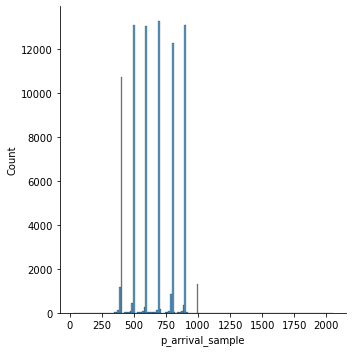

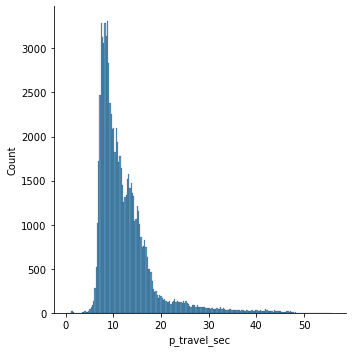

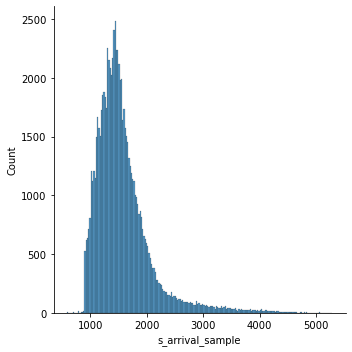

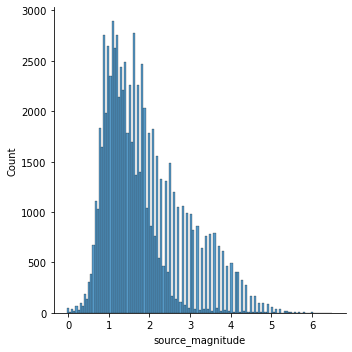

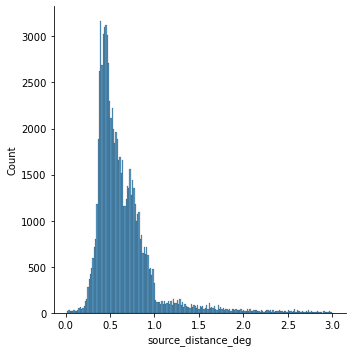

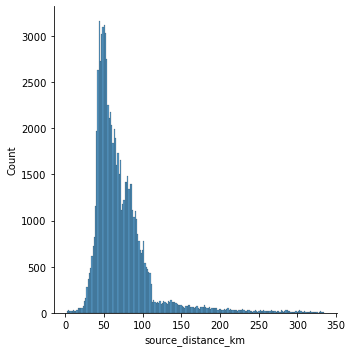

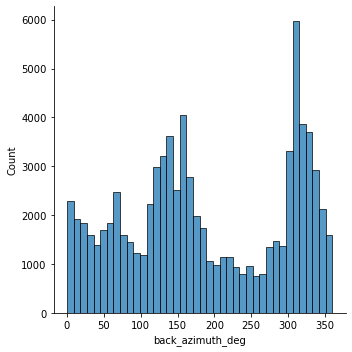

In [9]:
toVisualise = ['p_arrival_sample', 'p_travel_sec', 's_arrival_sample', 'source_magnitude',
               'source_distance_deg', 'source_distance_km', 'back_azimuth_deg']

for i in processedChunk.columns.tolist():
    if i in toVisualise:
        sb.displot(data = processedChunk, x = i)

plt.show()

In [12]:
processedChunk[toVisualise].describe()

,p_arrival_sample,p_travel_sec,s_arrival_sample,source_magnitude,source_distance_deg,source_distance_km,back_azimuth_deg
count,81750.000000,81750.000000,81750.000000,81750.000000,81750.000000,81750.000000,81750.000000
mean,658.620427,12.300425,1574.202751,1.808941,0.650188,72.272501,188.437866
std,174.491611,5.860125,505.350943,0.922270,0.356791,39.619941,108.115624
min,26.000000,0.290000,584.000000,-0.030000,0.015780,1.760000,0.000000
25%,500.000000,8.490000,1258.000000,1.120000,0.438300,48.730000,107.700000
50%,697.000000,10.680000,1469.000000,1.590000,0.557000,61.910000,167.200000
75%,800.000000,14.180000,1741.000000,2.260000,0.750400,83.470000,305.600000
max,2048.600000,55.910000,5287.000000,6.500000,3.000000,334.150000,360.000000
